In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(palette="deep")


In [2]:
df = pd.read_parquet(
    "../../../data/out/cot_entropy/mmlu_phi4mini_w_fallback_v2.parquet", engine="pyarrow"
)  # or engine='fastparquet'

# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

In [3]:
mmlu_entropy_df = df
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,False,"[0.739037036895752, 1.6074764728546143, 0.2694...","[[{""token_idx"": 16, ""token_prob"": 0.0056026899...",350,To determine the most compelling criticism of ...,"{""min"": [-1.765625, -2.25, -1.0078125, -1.5546...","{""min"": [-2.0, -1.2890625, -0.97265625, -1.742...","{""min"": [0.08251953125, -0.859375, 0.36328125,..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.44923800230026245, 0.52848881483078, 0.0339...","[[{""token_idx"": 1, ""token_prob"": 1.20153881653...",298,To determine which of the given articles are n...,"{""min"": [-1.734375, -2.078125, -0.51953125, -1...","{""min"": [-1.9765625, -1.734375, -0.7421875, -1...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7827358245849609, 1.3739895820617676, 0.138...","[[{""token_idx"": 12, ""token_prob"": 1.3965139260...",364,"To determine the correct answer, let's analyze...","{""min"": [-1.7734375, -2.375, -0.314453125, -1....","{""min"": [-1.7734375, -1.6953125, -0.306640625,...","{""min"": [0.130859375, -0.953125, 0.306640625, ..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.5698917508125305, 1.2224339246749878, 0.058...","[[{""token_idx"": 16, ""token_prob"": 0.0010091802...",345,"To find the total cost of the rental, we need ...","{""min"": [-1.828125, -2.140625, -0.376953125, -...","{""min"": [-1.890625, -1.7265625, -0.72265625, -...","{""min"": [-0.0869140625, -1.0, 0.60546875, 0.87..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.7429015040397644, 1.2687288522720337, 0.218...","[[{""token_idx"": 16, ""token_prob"": 0.0020184428...",278,"To solve this problem, we need to follow these...","{""min"": [-1.8203125, -2.1875, -0.58984375, -0....","{""min"": [-2.0, -2.28125, -1.1328125, -2.0625, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1...."


In [4]:
mmlu_entropy_df.value_counts("phi3_ans_token_index", dropna=False)

phi3_ans_token_index
-1       669
 419      49
 370      48
 415      43
 378      42
        ... 
 919       1
 915       1
 913       1
 677       1
 1021      1
Name: count, Length: 896, dtype: int64

In [5]:
# Filter out unanswered questions (phi3_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["phi3_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11363 after filtering


In [6]:
def entropy_counter(arr):
    sum = 0
    for i in arr:
        sum -= i["token_prob"] * np.log(i["token_prob"])
    return sum

In [7]:
import json

import matplotlib.pyplot as plt
import numpy as np


def extract_cot_answer_from_row(tokenizer, row, column_every_token_info, column_ans_token_index):
    every_token_info = json.loads(row[column_every_token_info])
    answer_token_probs = every_token_info[row[column_ans_token_index]]

    max_prob_idx = np.argmax([item["token_prob"] for item in answer_token_probs])
    answer_token = answer_token_probs[max_prob_idx]["token_idx"]
    return tokenizer.decode(answer_token)


def extract_cot_answer_entropy_from_row(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    return answer_token_entropy


def visualize_entropy_all(df, x, hue, model_name=None):
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="dodge",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
    plt.legend(
        handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer", loc="upper right"
    )
    if model_name is not None:
        plt.title(model_name)
    # plt.savefig("entropy_phi3.pdf")

    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="fill",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Proportion")
    plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")
    if model_name is not None:
        plt.title(model_name)


In [8]:
import ast

len(ast.literal_eval(mmlu_entropy_df_filtered.phi3_entropies.iloc[0]))

353

In [9]:
from transformers import AutoTokenizer

# from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "microsoft/Phi-4-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "phi3_every_token_info", "phi3_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/1448455552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/1448455552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(


In [10]:
[
    tokenizer.encode(".\n\n"),
    tokenizer.encode(".\n"),
    tokenizer.encode("\n"),
    tokenizer.encode("\n\n"),
    tokenizer.encode(":\n\n"),
    tokenizer.encode(":\n"),
    tokenizer.encode("]\n"),
    tokenizer.encode("]\n\n"),
    tokenizer.encode(";\n\n"),
    tokenizer.encode(";\n"),
    tokenizer.encode(";"),
    tokenizer.encode("..."),
    tokenizer.encode("**\n\n"),
    tokenizer.encode("**\n"),
    tokenizer.encode("*\n\n"),
    tokenizer.encode("*\n"),
]

[[364],
 [558],
 [198],
 [279],
 [1402],
 [734],
 [1592],
 [3144],
 [502],
 [307],
 [26],
 [1008],
 [91587],
 [1612],
 [26289],
 [6658]]

In [11]:
ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[0])[-1]

[{'token_idx': 13, 'token_prob': 0.002468241611495614},
 {'token_idx': 350, 'token_prob': 1.46766988109448e-05},
 {'token_idx': 364, 'token_prob': 0.0006240691291168332},
 {'token_idx': 558, 'token_prob': 0.00012288650032132864},
 {'token_idx': 887, 'token_prob': 1.6630880054435693e-05},
 {'token_idx': 1202, 'token_prob': 3.989540346083231e-05},
 {'token_idx': 2499, 'token_prob': 6.577640306204557e-05},
 {'token_idx': 3692, 'token_prob': 1.0087137525260914e-05},
 {'token_idx': 4707, 'token_prob': 2.741968637565151e-05},
 {'token_idx': 7816, 'token_prob': 1.2952142242284026e-05},
 {'token_idx': 8476, 'token_prob': 1.0087137525260914e-05},
 {'token_idx': 15227, 'token_prob': 1.6630880054435693e-05},
 {'token_idx': 199999, 'token_prob': 0.00015778938541188836},
 {'token_idx': 200020, 'token_prob': 0.9957596659660339}]

In [12]:
tokenizer.decode(200020)

'<|end|>'

In [13]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        maxi = 0
        maxii = 0
        for i in sublist:
            if i["token_prob"] > maxi:
                maxii = maxi
                maxi = i["token_prob"]
        prob_max.append(1 - (maxi - maxii))
    return np.mean(prob_max)
    # return


mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/2839129350.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(


In [14]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(np.max([item["token_prob"] for item in sublist]))

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)


def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(sublist[np.argmax([item["token_prob"] for item in sublist])]["token_idx"])

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/230375516.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/230375516.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(


In [15]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.mean([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/857436923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(


In [16]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.max([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/93196006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(


In [17]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    # return np.mean([ind for ind in entropies])
    return np.abs(np.max([ind for ind in entropies]) - answer_token_entropy)


mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/4097516008.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(


In [18]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # ev = json.loads(row[every])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    top1, top2 = sorted(entropies, reverse=True)[:2]

    return abs(top1 - top2)
    # why = np.argmax([ind['token_prob'] for ind in ast.literal_eval(row[every])[check]])

    # piv = ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[ran])[check][why]['token_idx']


mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_39532/326559772.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(


In [19]:
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


@dataclass
class ROC_AUC:
    roc_auc: float
    gini: float


def calculate_roc_auc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * roc_auc - 1)
    return ROC_AUC(roc_auc=roc_auc, gini=gini)


def calculate_accuracy(df, model_answer_correct_col):
    return df[model_answer_correct_col].sum() / len(df)


def calculate_roc_auc_by_category(df, model_name, category_col, model_answer_correct_col, score_col, threshold=10):
    results = []

    roc_auc = calculate_roc_auc(df[model_answer_correct_col], normalize_score(df[score_col]))

    results.append(
        {
            "category": "ALL",
            "roc_auc": roc_auc.roc_auc,
            "gini": roc_auc.gini,
            "num_samples": len(df),
            "accuracy": calculate_accuracy(df, model_answer_correct_col),
            "model": model_name,
            "metric": score_col,
        }
    )

    for category in df[category_col].unique():
        df_cat = df[df[category_col] == category]
        if len(df_cat) < threshold:
            continue

        roc_auc = calculate_roc_auc(df_cat[model_answer_correct_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": roc_auc.roc_auc,
                "gini": roc_auc.gini,
                "num_samples": len(df_cat),
                "accuracy": calculate_accuracy(df_cat, model_answer_correct_col),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)

In [20]:
option_ids = [str(i + 1) for i in range(20)]
# 0 is a special exception for "do not know"
option_ids_w_fallback = option_ids + ["0"]


def validate_mmlu_answer(answer):
    return str(answer) in option_ids_w_fallback


def keep_only_valid_and_known_answers(df, column_name, option_ids=option_ids):
    return df[df[column_name].isin(option_ids)]

In [21]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
# from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "phi3_answer")

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

phi3_answer
1         1402
0         1371
2         1232
4         1211
3         1200
6          914
7          913
5          885
8          854
9          715
10         633
12           4
11           3
16           2
432          1
420          1
428          1
52           1
438          1
491          1
40           1
78           1
608          1
-            1
36           1
34           1
280          1
27           1
256          1
25           1
20           1
18           1
17           1
164          1
160          1
15           1
13           1
number       1
Name: count, dtype: int64
phi3_answer
1     1402
2     1232
4     1211
3     1200
6      914
7      913
5      885
8      854
9      715
10     633
12       4
11       3
16       2
13       1
15       1
17       1
18       1
20       1
Name: count, dtype: int64


In [22]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,...,phi3_answer_embeddings,phi3_answer,phi3_answer_entropy,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,...,"{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.009762,0.240888,"[0.8315128684043884, 0.47677022218704224, 0.92...","[1385, 11433, 290, 1645, 44655, 42893, 328, 10...",0.639666,3.013290,3.003528,0.015738
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,...,"{""min"": [0.1123046875, -0.921875, 0.5234375, 1...",5,1.013274,0.290829,"[0.9237420558929443, 0.8562420606613159, 0.995...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.747505,3.015365,2.002090,0.043623
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,...,"{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.050801,0.251949,"[0.8361507654190063, 0.5001430511474609, 0.970...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.610590,2.699257,2.648456,0.130351
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,...,"{""min"": [0.06640625, -1.015625, 0.44140625, 1....",9,0.264199,0.129641,"[0.8142979145050049, 0.42949527502059937, 0.95...","[1385, 17722, 495, 4792, 11, 581, 1309, 316, 2...",0.301936,2.292861,2.028662,0.031713
5,theoremQA-Finance,I,"['0.0', '-0.75', '-2.5', '-3.0', '2.5', '-2.0'...",business,Suppose the demand curve for oPads is given by...,NaN,139,8,74,Economics & Finance MCQs,...,"{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.044382,0.172662,"[0.9470300078392029, 0.49576884508132935, 0.99...","[1385, 11433, 290, 134809, 328, 290, 8492, 111...",0.383086,2.379871,2.335489,0.068242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,ori_mmlu-high_school_macroeconomics,D,['more effective in X because the policy will ...,economics,Economy X is an open economy with flexible exc...,NaN,7680,3,83,Economics & Finance MCQs,...,"{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.000826,0.221326,"[0.6793884038925171, 0.5451292991638184, 0.720...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.531314,2.564232,2.563406,0.061465
12027,ori_mmlu-high_school_macroeconomics,F,['Higher interest rates that result from borro...,economics,"The ""crowding-out"" effect refers to which of t...",NaN,7681,5,150,Economics & Finance MCQs,...,"{""min"": [0.10693359375, -1.203125, 0.306640625...",6,0.114095,0.143870,"[0.5182616710662842, 0.5989289879798889, 0.922...","[1385, 11433, 290, 6145, 6052, 11, 35717, 1577...",0.359106,2.418216,2.304122,0.192240
12028,ori_mmlu-high_school_macroeconomics,A,['Lower reserve requirements; lower the discou...,economics,Which of the following lists contains only Fed...,NaN,7683,0,124,Economics & Finance MCQs,...,"{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.000438,0.073896,"[0.798432469367981, 0.7505913972854614, 0.8793...","[1385, 11433, 1118, 1562, 8895, 1606, 28941, 1...",0.165916,2.289573,2.289134,0.019463
12030,ori_mmlu-high_school_macroeconomics,B,"['an increase in net exports', 'a decrease in ...",economics,A use of easy money (expansionary) policy by t...,NaN,7685,1,58,Economics & Finance MCQs,...,"{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.000390,0.230936,"[0.7074999809265137, 0.45726022124290466, 0.98...","[1385, 6052, 495, 4928, 11, 35717, 1577, 4218,...",0.535100,2.597710,2.597319,0.03743

<h2>Sequence mean entropy<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.621454,0.242909,9973,0.534343,Qwen-3b,phi3_answer_entropy_sequence_mean
1,law,0.482121,0.035758,1033,0.272023,Qwen-3b,phi3_answer_entropy_sequence_mean
2,business,0.686382,0.372764,636,0.650943,Qwen-3b,phi3_answer_entropy_sequence_mean
3,psychology,0.587464,0.174928,764,0.600785,Qwen-3b,phi3_answer_entropy_sequence_mean
4,chemistry,0.648269,0.296537,814,0.595823,Qwen-3b,phi3_answer_entropy_sequence_mean
5,biology,0.577866,0.155731,663,0.672700,Qwen-3b,phi3_answer_entropy_sequence_mean
6,history,0.558002,0.116005,358,0.374302,Qwen-3b,phi3_answer_entropy_sequence_mean
7,other,0.566814,0.133628,848,0.498821,Qwen-3b,phi3_answer_entropy_sequence_mean
8,physics,0.575714,0.151428,986,0.558824,Qwen-3b,phi3_answer_entropy_sequence_mean
9,computer science,0.559188,0.118375,327,0.547401,Qwen-3b,phi3_answer_entropy_sequence_mean


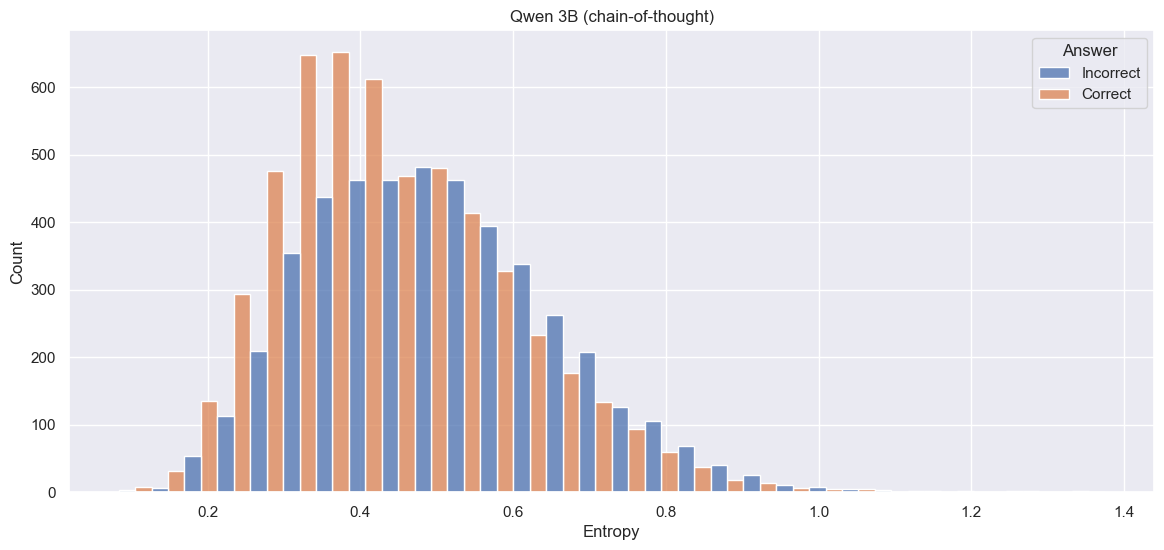

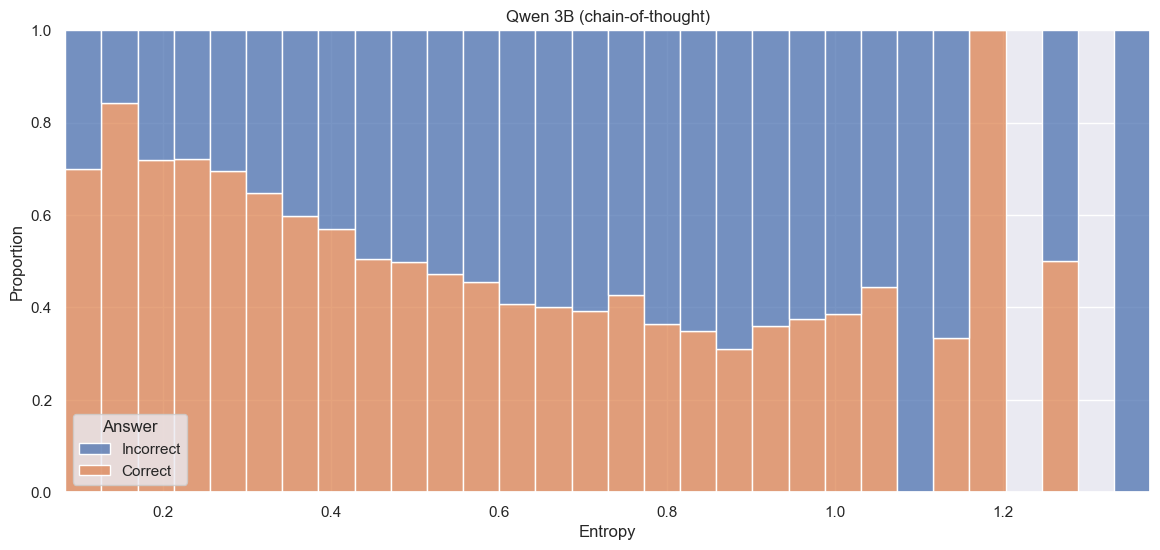

In [23]:
splitters = [364, 558, 198, 279, 1402, 734, 1592, 3144, 502, 307, 26, 1008, 91587, 1612, 26289, 6658, 200020]
name = "phi3_answer_entropy_sequence_mean"


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    # print()
    # answer_token_entropy = entropies[row[column_ans_token_index]]

    # top1, top2 = sorted(entropies, reverse=True)[:2]
    entr = []
    seq_entr = []
    counter = 0
    # print(row[args])
    for sublist in row[args]:
        # prob_max = np.argmax([item['token_prob'] for item in sublist])
        entr.append(entropies[counter])
        # print(entr)
        if sublist in splitters:
            # print(entr)
            seq_entr.append(np.mean(entr))
            # print(np.mean(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)


visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence mean max entropy<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.620858,0.241716,9973,0.534343,Qwen-3b,phi3_answer_entropy_sequence_mean_max
1,law,0.554256,0.108513,1033,0.272023,Qwen-3b,phi3_answer_entropy_sequence_mean_max
2,business,0.686828,0.373656,636,0.650943,Qwen-3b,phi3_answer_entropy_sequence_mean_max
3,psychology,0.548084,0.096168,764,0.600785,Qwen-3b,phi3_answer_entropy_sequence_mean_max
4,chemistry,0.625150,0.250299,814,0.595823,Qwen-3b,phi3_answer_entropy_sequence_mean_max
5,biology,0.609824,0.219648,663,0.672700,Qwen-3b,phi3_answer_entropy_sequence_mean_max
6,history,0.579924,0.159848,358,0.374302,Qwen-3b,phi3_answer_entropy_sequence_mean_max
7,other,0.597202,0.194404,848,0.498821,Qwen-3b,phi3_answer_entropy_sequence_mean_max
8,physics,0.533404,0.066809,986,0.558824,Qwen-3b,phi3_answer_entropy_sequence_mean_max
9,computer science,0.599275,0.198551,327,0.547401,Qwen-3b,phi3_answer_entropy_sequence_mean_max


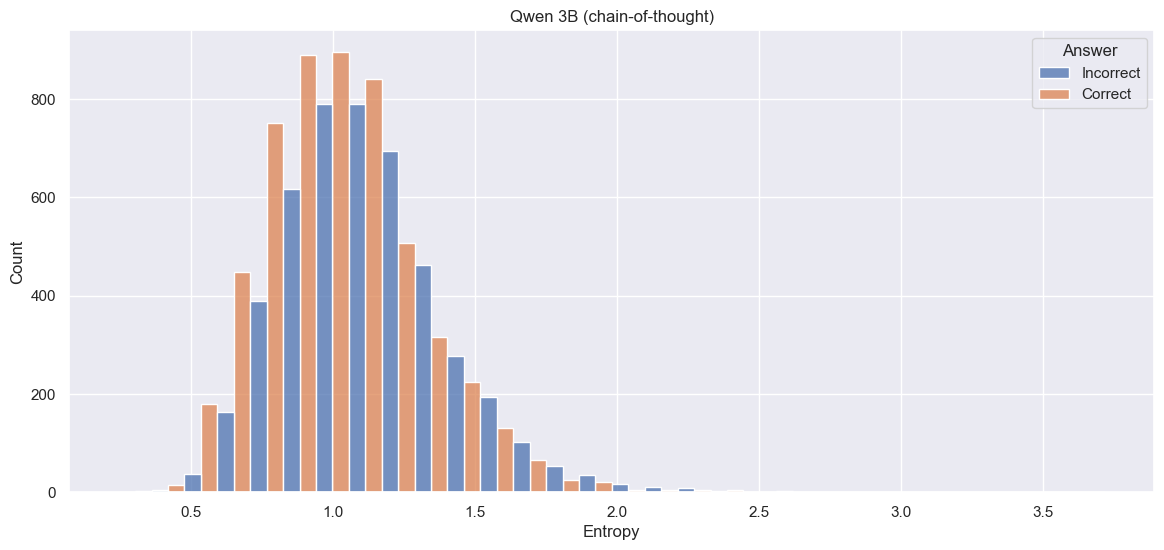

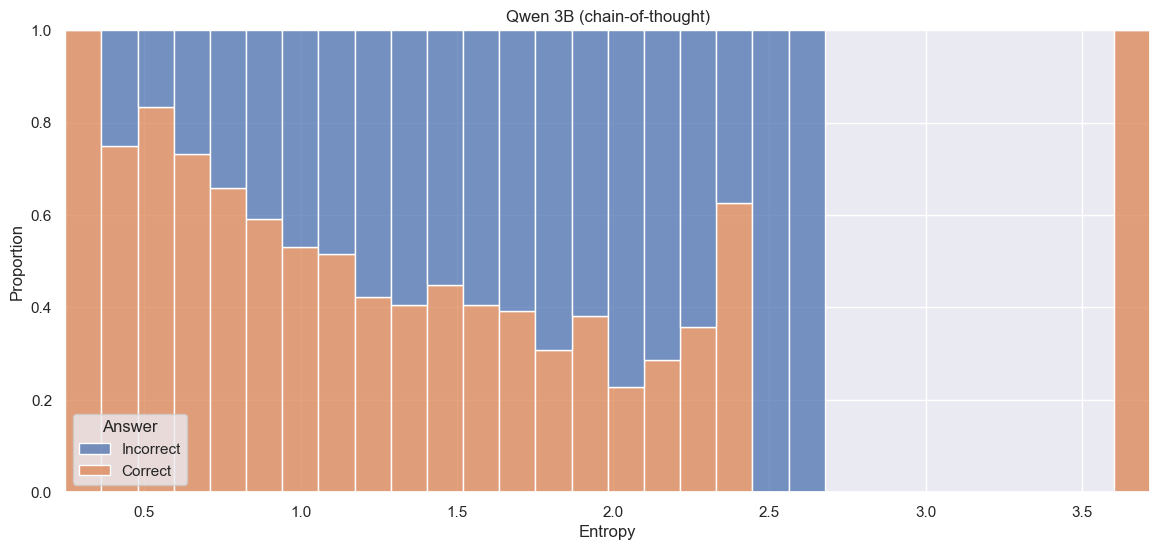

In [24]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.mean(entr))

            entr = []
        counter += 1
    return np.max(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_mean_max"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence max mean entropy<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.612435,0.224870,9973,0.534343,Qwen-3b,phi3_answer_entropy_sequence_max_mean
1,law,0.471937,0.056126,1033,0.272023,Qwen-3b,phi3_answer_entropy_sequence_max_mean
2,business,0.662978,0.325956,636,0.650943,Qwen-3b,phi3_answer_entropy_sequence_max_mean
3,psychology,0.573378,0.146755,764,0.600785,Qwen-3b,phi3_answer_entropy_sequence_max_mean
4,chemistry,0.628866,0.257732,814,0.595823,Qwen-3b,phi3_answer_entropy_sequence_max_mean
5,biology,0.586349,0.172697,663,0.672700,Qwen-3b,phi3_answer_entropy_sequence_max_mean
6,history,0.569863,0.139725,358,0.374302,Qwen-3b,phi3_answer_entropy_sequence_max_mean
7,other,0.560389,0.120779,848,0.498821,Qwen-3b,phi3_answer_entropy_sequence_max_mean
8,physics,0.591372,0.182744,986,0.558824,Qwen-3b,phi3_answer_entropy_sequence_max_mean
9,computer science,0.564548,0.129096,327,0.547401,Qwen-3b,phi3_answer_entropy_sequence_max_mean


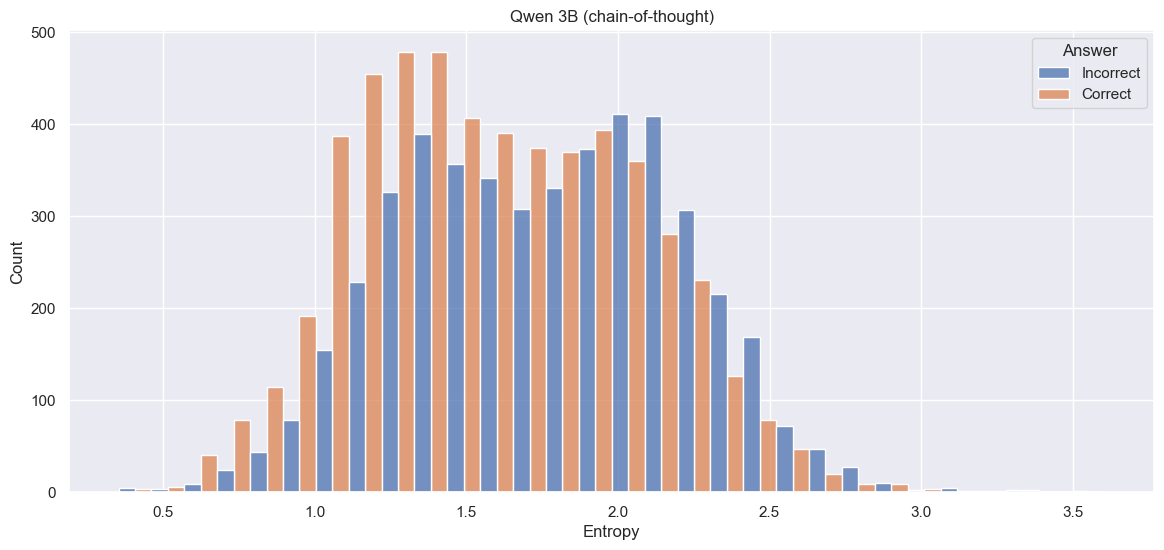

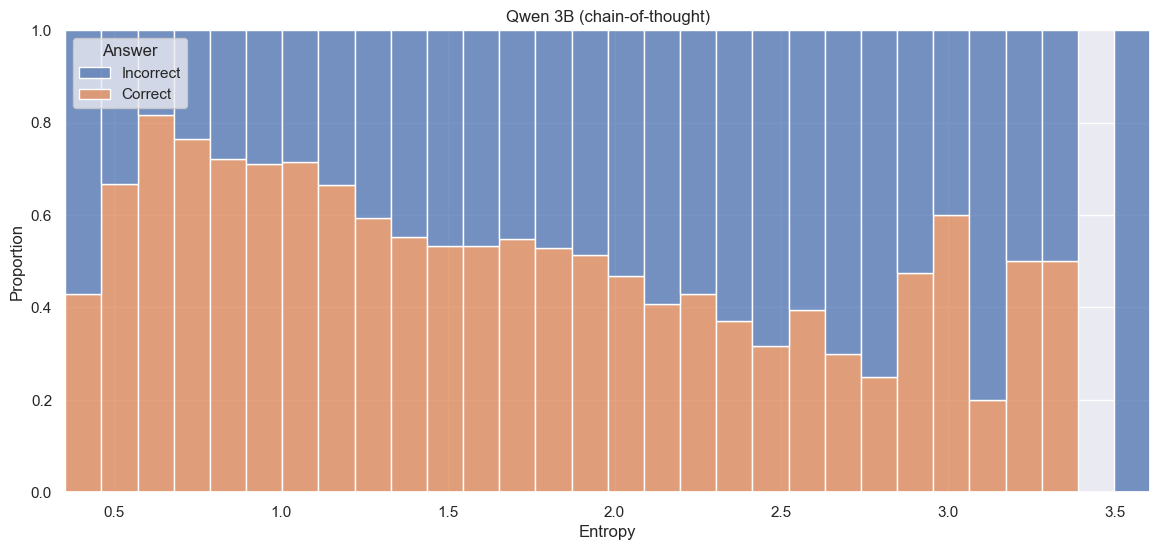

In [25]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.max(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_max_mean"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [26]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,...,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff,phi3_answer_entropy_sequence_mean,phi3_answer_entropy_sequence_mean_max,phi3_answer_entropy_sequence_max_mean
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,...,0.240888,"[0.8315128684043884, 0.47677022218704224, 0.92...","[1385, 11433, 290, 1645, 44655, 42893, 328, 10...",0.639666,3.013290,3.003528,0.015738,0.476719,0.943046,1.697956
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,...,0.290829,"[0.9237420558929443, 0.8562420606613159, 0.995...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.747505,3.015365,2.002090,0.043623,0.736304,1.098733,2.159111
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,...,0.251949,"[0.8361507654190063, 0.5001430511474609, 0.970...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.610590,2.699257,2.648456,0.130351,0.569739,1.009380,1.823549
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,...,0.129641,"[0.8142979145050049, 0.42949527502059937, 0.95...","[1385, 17722, 495, 4792, 11, 581, 1309, 316, 2...",0.301936,2.292861,2.028662,0.031713,0.328589,0.671937,1.466674
5,theoremQA-Finance,I,"['0.0', '-0.75', '-2.5', '-3.0', '2.5', '-2.0'...",business,Suppose the demand curve for oPads is given by...,NaN,139,8,74,Economics & Finance MCQs,...,0.172662,"[0.9470300078392029, 0.49576884508132935, 0.99...","[1385, 11433, 290, 134809, 328, 290, 8492, 111...",0.383086,2.379871,2.335489,0.068242,0.338871,0.886523,1.249712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,ori_mmlu-high_school_macroeconomics,D,['more effective in X because the policy will ...,economics,Economy X is an open economy with flexible exc...,NaN,7680,3,83,Economics & Finance MCQs,...,0.221326,"[0.6793884038925171, 0.5451292991638184, 0.720...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.531314,2.564232,2.563406,0.061465,0.526151,1.102582,1.949546
12027,ori_mmlu-high_school_macroeconomics,F,['Higher interest rates that result from borro...,economics,"The ""crowding-out"" effect refers to which of t...",NaN,7681,5,150,Economics & Finance MCQs,...,0.143870,"[0.5182616710662842, 0.5989289879798889, 0.922...","[1385, 11433, 290, 6145, 6052, 11, 35717, 1577...",0.359106,2.418216,2.304122,0.192240,0.352814,0.934813,1.752001
12028,ori_mmlu-high_school_macroeconomics,A,['Lower reserve requirements; lower the discou...,economics,Which of the following lists contains only Fed...,NaN,7683,0,124,Economics & Finance MCQs,...,0.073896,"[0.798432469367981, 0.7505913972854614, 0.8793...","[1385, 11433, 1118, 1562, 8895, 1606, 28941, 1...",0.165916,2.289573,2.289134,0.019463,0.103604,0.921732,0.455118
12030,ori_mmlu-high_school_macroeconomics,B,"['an increase in net exports', 'a decrease in ...",economics,A use of easy money (expansionary) policy by t...,NaN,7685,1,58,Economics & Finance MCQs,...,0.230936,"[0.7074999809265137, 0.45726022124290466, 0.98...","[1385, 6052, 495, 4928, 11, 35717, 1577, 4218,...",0.535100,2.597710,2.597319,0.037431,0.522448,0.739034,2.034882


<h2>Entropy of Answer<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.602301,0.204601,9973,0.534343,Qwen-3b,phi3_answer_entropy
1,law,0.540315,0.080630,1033,0.272023,Qwen-3b,phi3_answer_entropy
2,business,0.559309,0.118619,636,0.650943,Qwen-3b,phi3_answer_entropy
3,psychology,0.685224,0.370449,764,0.600785,Qwen-3b,phi3_answer_entropy
4,chemistry,0.637251,0.274503,814,0.595823,Qwen-3b,phi3_answer_entropy
5,biology,0.712405,0.424810,663,0.672700,Qwen-3b,phi3_answer_entropy
6,history,0.545742,0.091485,358,0.374302,Qwen-3b,phi3_answer_entropy
7,other,0.605779,0.211559,848,0.498821,Qwen-3b,phi3_answer_entropy
8,physics,0.617260,0.234520,986,0.558824,Qwen-3b,phi3_answer_entropy
9,computer science,0.611430,0.222860,327,0.547401,Qwen-3b,phi3_answer_entropy


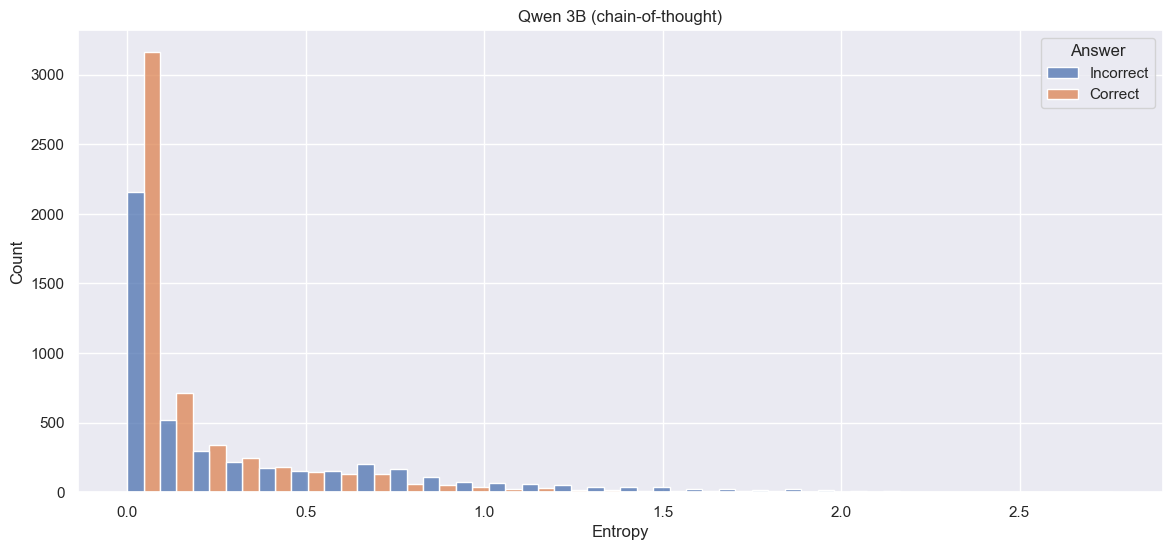

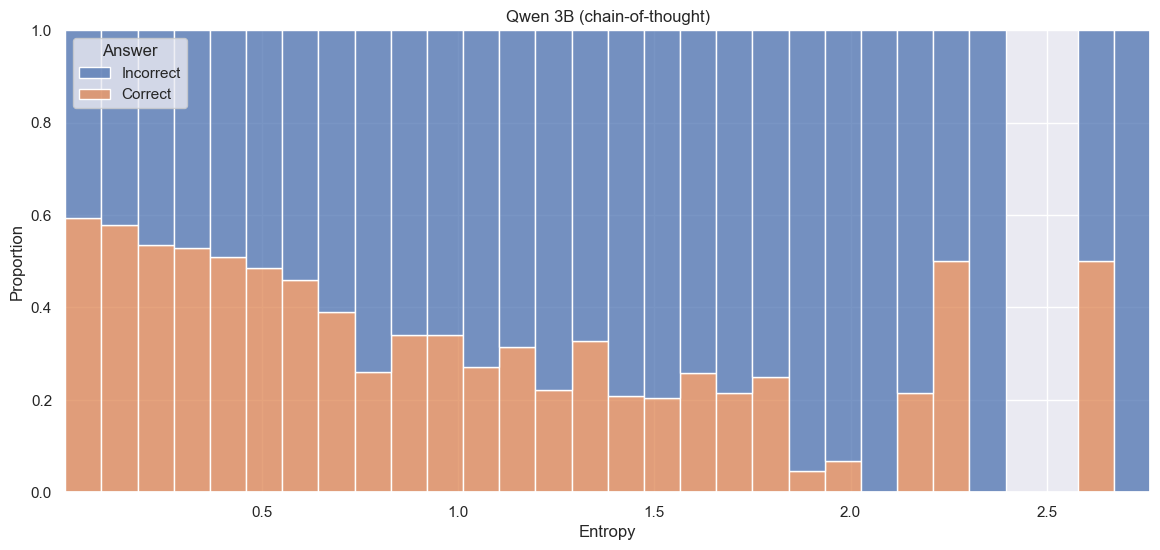

In [27]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy",
    model_name=model_title,
)
roc_auc_res

<h2>COT max entropy<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.648419,0.296839,9973,0.534343,Qwen-3b,phi3_answer_entropy_cot_max
1,law,0.506512,0.013023,1033,0.272023,Qwen-3b,phi3_answer_entropy_cot_max
2,business,0.712887,0.425774,636,0.650943,Qwen-3b,phi3_answer_entropy_cot_max
3,psychology,0.556220,0.112440,764,0.600785,Qwen-3b,phi3_answer_entropy_cot_max
4,chemistry,0.648595,0.297189,814,0.595823,Qwen-3b,phi3_answer_entropy_cot_max
5,biology,0.623422,0.246843,663,0.672700,Qwen-3b,phi3_answer_entropy_cot_max
6,history,0.609108,0.218217,358,0.374302,Qwen-3b,phi3_answer_entropy_cot_max
7,other,0.605462,0.210925,848,0.498821,Qwen-3b,phi3_answer_entropy_cot_max
8,physics,0.615662,0.231324,986,0.558824,Qwen-3b,phi3_answer_entropy_cot_max
9,computer science,0.628416,0.256832,327,0.547401,Qwen-3b,phi3_answer_entropy_cot_max


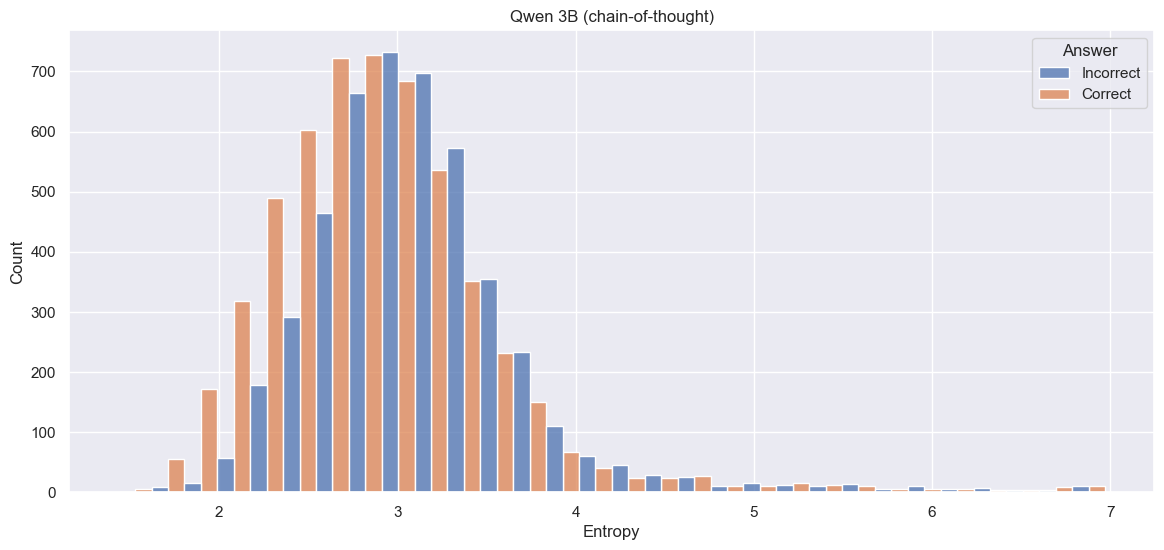

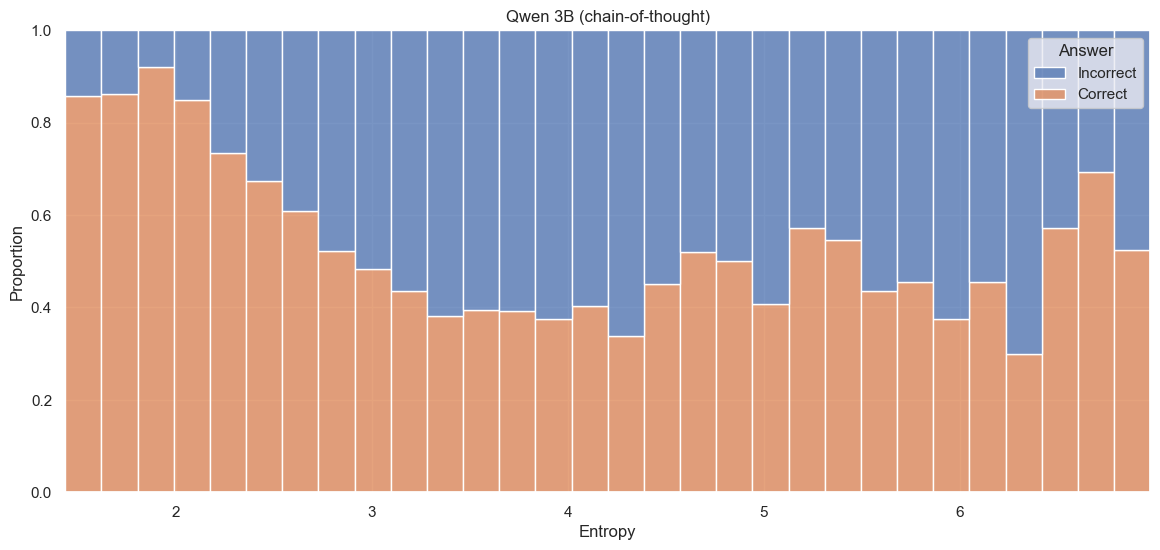

In [28]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_cot_max", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_max",
    model_name=model_title,
)
roc_auc_res


<h2>COT mean entropy<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.627305,0.254610,9973,0.534343,Qwen-3b,phi3_answer_entropy_cot_mean
1,law,0.475080,0.049841,1033,0.272023,Qwen-3b,phi3_answer_entropy_cot_mean
2,business,0.698916,0.397833,636,0.650943,Qwen-3b,phi3_answer_entropy_cot_mean
3,psychology,0.602014,0.204029,764,0.600785,Qwen-3b,phi3_answer_entropy_cot_mean
4,chemistry,0.650487,0.300975,814,0.595823,Qwen-3b,phi3_answer_entropy_cot_mean
5,biology,0.588167,0.176334,663,0.672700,Qwen-3b,phi3_answer_entropy_cot_mean
6,history,0.560501,0.121002,358,0.374302,Qwen-3b,phi3_answer_entropy_cot_mean
7,other,0.576031,0.152062,848,0.498821,Qwen-3b,phi3_answer_entropy_cot_mean
8,physics,0.594852,0.189703,986,0.558824,Qwen-3b,phi3_answer_entropy_cot_mean
9,computer science,0.559188,0.118375,327,0.547401,Qwen-3b,phi3_answer_entropy_cot_mean


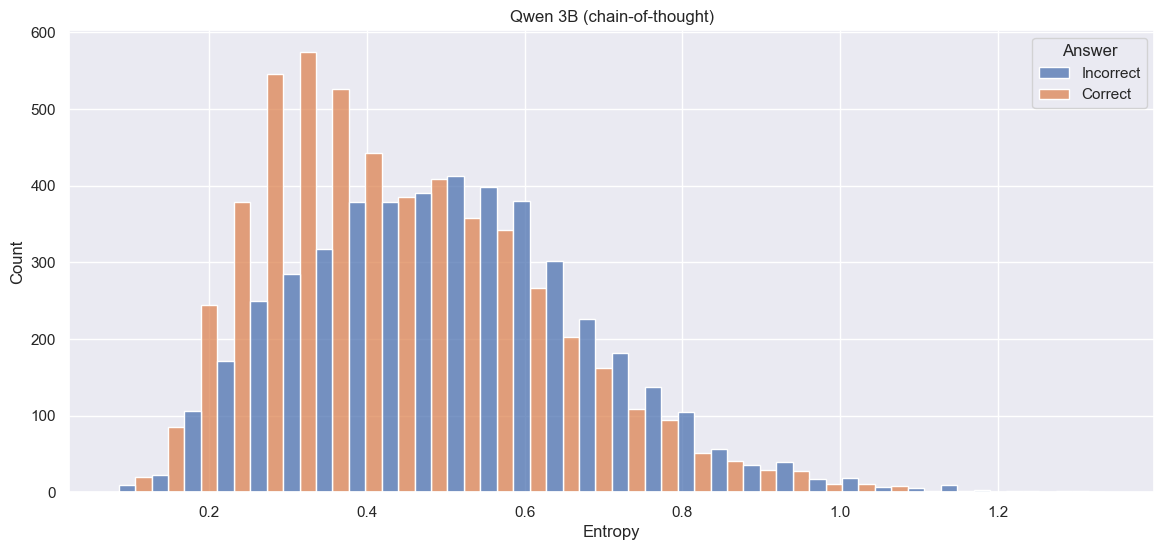

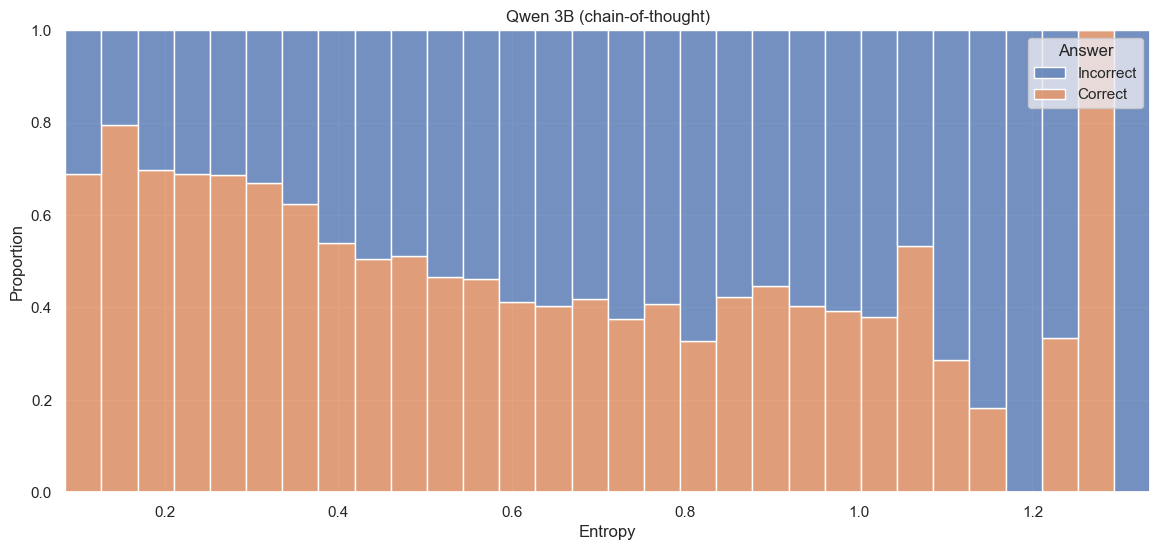

In [29]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_cot_mean",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_mean",
    model_name=model_title,
)
roc_auc_res


<h2>Max COT entropy and answer entropy difference<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.563928,0.127857,9973,0.534343,Qwen-3b,phi3_answer_entropy_marg
1,law,0.473717,0.052567,1033,0.272023,Qwen-3b,phi3_answer_entropy_marg
2,business,0.617541,0.235083,636,0.650943,Qwen-3b,phi3_answer_entropy_marg
3,psychology,0.448895,0.102211,764,0.600785,Qwen-3b,phi3_answer_entropy_marg
4,chemistry,0.543979,0.087958,814,0.595823,Qwen-3b,phi3_answer_entropy_marg
5,biology,0.480503,0.038995,663,0.672700,Qwen-3b,phi3_answer_entropy_marg
6,history,0.554071,0.108142,358,0.374302,Qwen-3b,phi3_answer_entropy_marg
7,other,0.540242,0.080484,848,0.498821,Qwen-3b,phi3_answer_entropy_marg
8,physics,0.515902,0.031804,986,0.558824,Qwen-3b,phi3_answer_entropy_marg
9,computer science,0.517817,0.035633,327,0.547401,Qwen-3b,phi3_answer_entropy_marg


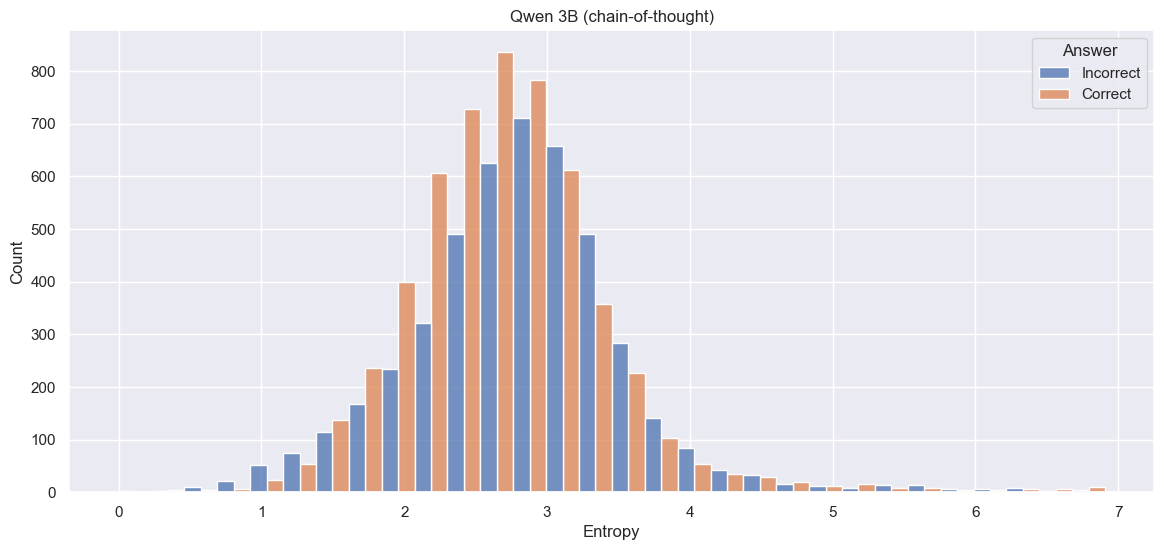

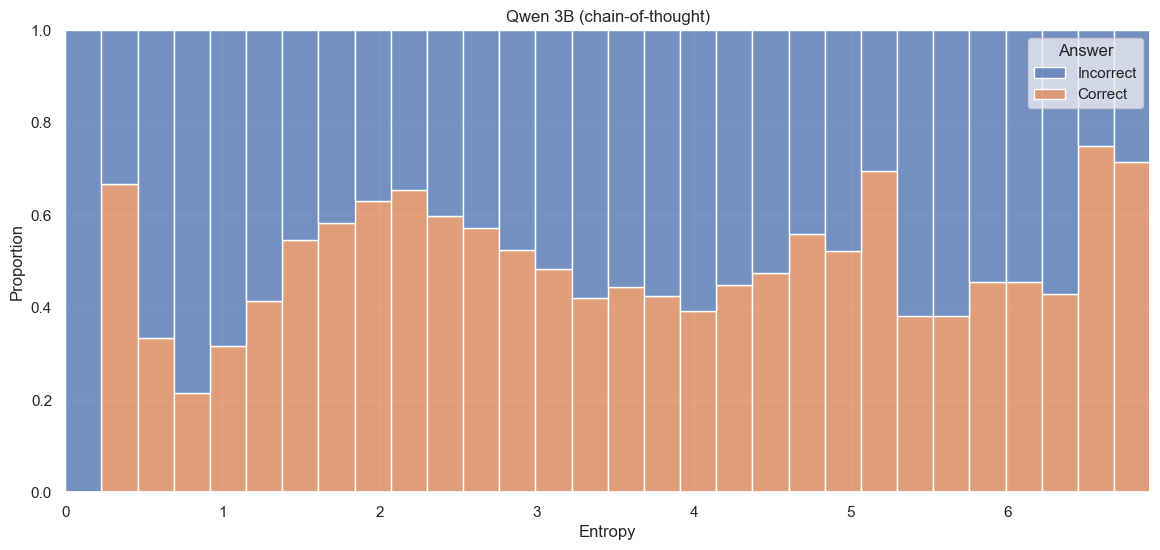

In [30]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_marg", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_marg",
    model_name=model_title,
)
roc_auc_res

<h2>Mean of Marginal difference of 2 highest probs for each token<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.611113,0.222226,9973,0.534343,Qwen-3b,phi3_prob_diff_ent
1,law,0.459822,0.080355,1033,0.272023,Qwen-3b,phi3_prob_diff_ent
2,business,0.670573,0.341145,636,0.650943,Qwen-3b,phi3_prob_diff_ent
3,psychology,0.585785,0.171570,764,0.600785,Qwen-3b,phi3_prob_diff_ent
4,chemistry,0.627920,0.255839,814,0.595823,Qwen-3b,phi3_prob_diff_ent
5,biology,0.569641,0.139282,663,0.672700,Qwen-3b,phi3_prob_diff_ent
6,history,0.555604,0.111207,358,0.374302,Qwen-3b,phi3_prob_diff_ent
7,other,0.561558,0.123115,848,0.498821,Qwen-3b,phi3_prob_diff_ent
8,physics,0.578876,0.157753,986,0.558824,Qwen-3b,phi3_prob_diff_ent
9,computer science,0.542881,0.085762,327,0.547401,Qwen-3b,phi3_prob_diff_ent


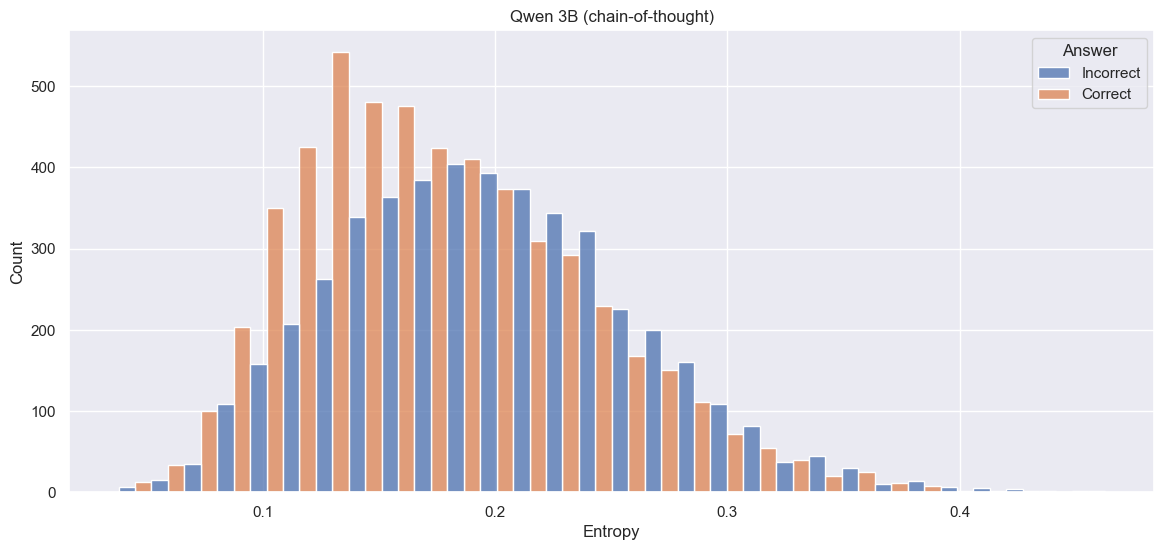

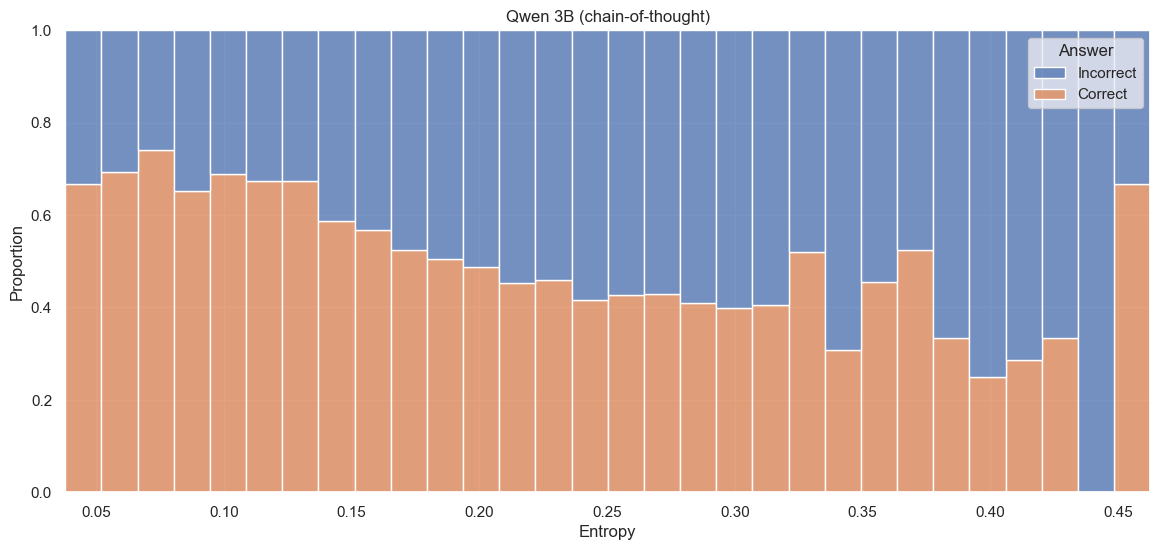

In [31]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_prob_diff_ent", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_prob_diff_ent",
    model_name=model_title,
)
roc_auc_res


<h2>Answer Entropy and Max COT mixed<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.633900,0.267799,9973,0.534343,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
1,law,0.541025,0.082049,1033,0.272023,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
2,business,0.598566,0.197132,636,0.650943,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
3,psychology,0.693096,0.386192,764,0.600785,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
4,chemistry,0.654222,0.308445,814,0.595823,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
5,biology,0.735550,0.471100,663,0.672700,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
6,history,0.596682,0.193364,358,0.374302,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
7,other,0.616532,0.233064,848,0.498821,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
8,physics,0.627069,0.254138,986,0.558824,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
9,computer science,0.634493,0.268987,327,0.547401,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix


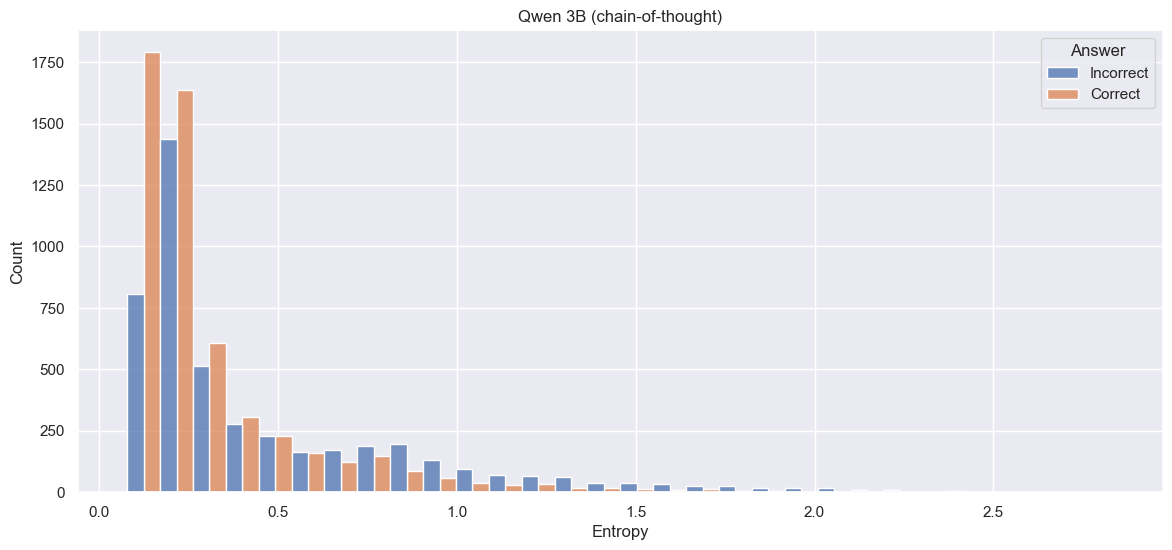

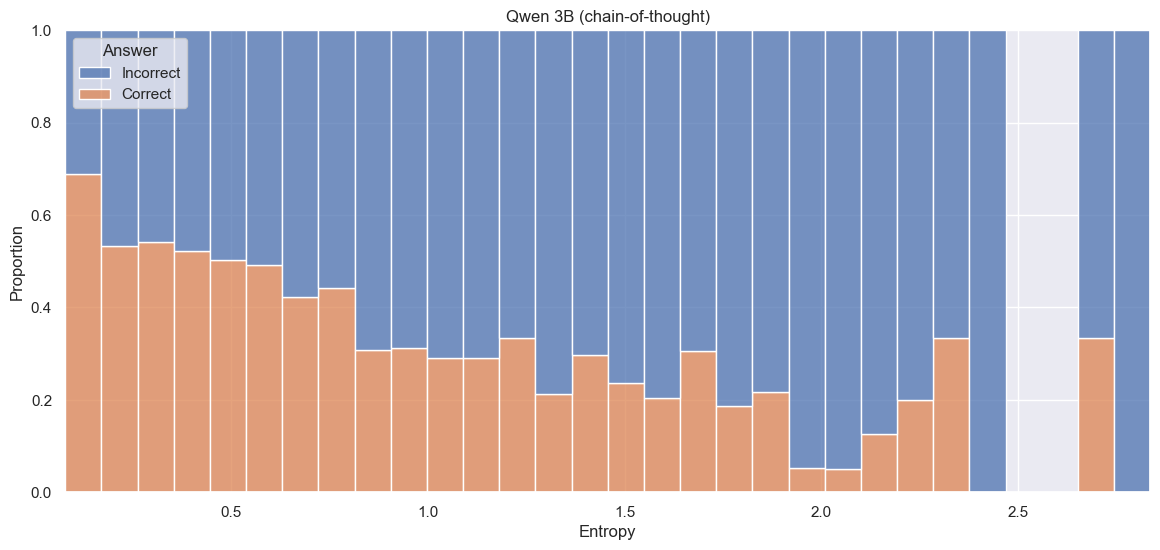

In [32]:
name = "phi3_answer_entropy_max_ans_entropy_mix"


def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    answer_token_entropy = entropies[row[column_ans_token_index]]
    return 0.05 * np.max([ind for ind in entropies]) + 0.95 * answer_token_entropy


mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Diff of 2 highest entropies<h2>


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.504120,0.008239,9973,0.534343,Qwen-3b,phi3_answer_entropy_top_diff
1,law,0.486915,0.026170,1033,0.272023,Qwen-3b,phi3_answer_entropy_top_diff
2,business,0.512850,0.025700,636,0.650943,Qwen-3b,phi3_answer_entropy_top_diff
3,psychology,0.516433,0.032865,764,0.600785,Qwen-3b,phi3_answer_entropy_top_diff
4,chemistry,0.527754,0.055507,814,0.595823,Qwen-3b,phi3_answer_entropy_top_diff
5,biology,0.498667,0.002666,663,0.672700,Qwen-3b,phi3_answer_entropy_top_diff
6,history,0.562233,0.124467,358,0.374302,Qwen-3b,phi3_answer_entropy_top_diff
7,other,0.489996,0.020008,848,0.498821,Qwen-3b,phi3_answer_entropy_top_diff
8,physics,0.491316,0.017369,986,0.558824,Qwen-3b,phi3_answer_entropy_top_diff
9,computer science,0.512155,0.024309,327,0.547401,Qwen-3b,phi3_answer_entropy_top_diff


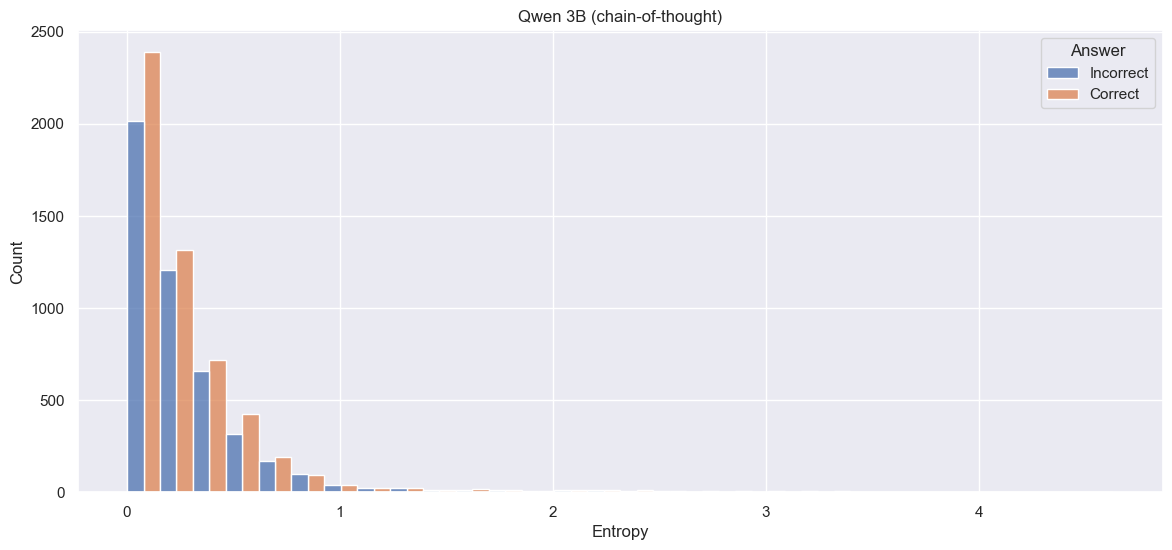

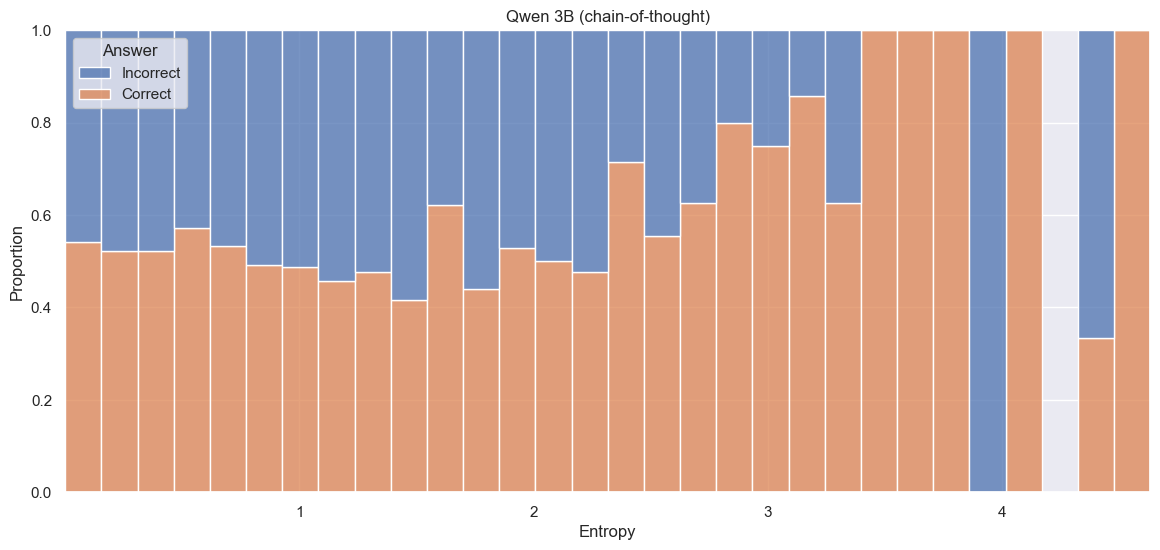

In [33]:
# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_top_diff",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_top_diff",
    model_name=model_title,
)
roc_auc_res
